# Constrained ILC


In this short tutorial, we will:

1. Define a stamp geometry
2. Generate random simulations of the CMB
3. Initialize an gaussian profile
4. Create a mock catalog of tSZ clusters with gaussian profile at 220 GHz, 150 GHz, 90 GHz
6. Do aperture photometry on Standard ILC and Constrained ILC reconstructions of the compton Y and of the CMB


In [1]:
%load_ext autoreload
%autoreload 2
from __future__ import print_function

# The main mapwork module
from enlib import enmap

import numpy as np
import matplotlib.pyplot as plt

# Tools for working with enmaps, i/o, catalogs and statistics
from orphics import maps,io,stats,cosmology,lensing


In [2]:
# Let's define a geometry centered on the equator by default

shape,wcs = maps.rect_geometry(width_arcmin=40.,px_res_arcmin=0.5)

# shape gives us the shape of the numpy matrix storing the map

print(shape)

# wcs is the World Coordinate System info that tells enlib what pixels correspond to what locations on the sky.
# Enlib essentially extends the numpy array to include wcs information

print(wcs)

(80, 80)
car:{cdelt:[0.008333,0.008333],crval:[0,0],crpix:[40.5,40.5]}


In [3]:
# What are the bounds of this geometry in arcmin?
bounds = enmap.box(shape,wcs)*60.*180./np.pi
print(bounds)

[[-20. -20.]
 [ 20.  20.]]


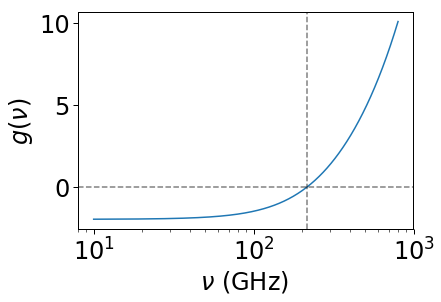

tSZ response at  90.0  GHz =  -1.5979481689284043
tSZ response at  150.0  GHz =  -0.9533273348182751
tSZ response at  220.0  GHz =  0.03829704798299893
tSZ response at  217  GHz =  -0.007777597181995777


In [4]:
# Set up SZ frequency dependence
def gnu(nu_ghz,tcmb=2.7255):
    nu = 1e9*nu_ghz
    hplanck = 6.62607e-34
    kboltzmann = 1.38065e-23 
    x = hplanck*nu/kboltzmann/tcmb
    coth = np.cosh(x/2.)/np.sinh(x/2.)
    return x*coth-4.


null_nu = 217
nus = np.logspace(np.log10(10),np.log10(800),1000)
gnus = gnu(nus)
pl = io.Plotter(xlabel="$\\nu$ (GHz) ",ylabel="$g(\\nu)$",xscale='log')
pl.add(nus,gnus)
pl.hline()
pl.vline(x=null_nu)
pl.done()

test_nus = [90.,150.,220.,null_nu]
for nu in test_nus:
    print("tSZ response at ", nu, " GHz = ", gnu(nu))


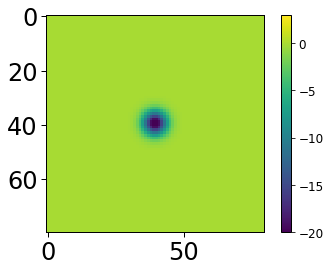

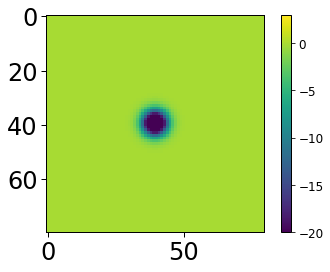

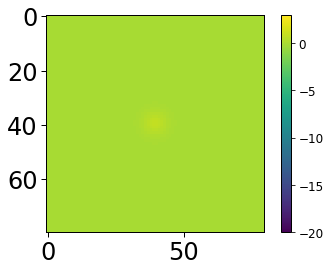

In [8]:
# Peak Compton-y values
logymin = -6
logymax = -4
Nclusters = 500
logys = np.random.uniform(logymin,logymax,Nclusters)
ys = 10**logys

def szmap(ymap,nu_ghz,tcmb=2.7255):
    return gnu(nu_ghz,tcmb)*ymap*1e6


# Example simulated SZ map
scale_arcmin = 1.5
scale = scale_arcmin*np.pi/180./60.
modrmap = enmap.modrmap(shape,wcs)
ytemplate = np.exp(-modrmap**2./2./scale**2.)

io.plot_img(szmap(np.mean(ys)*ytemplate,150.),lim=[-20,3])
io.plot_img(szmap(np.mean(ys)*ytemplate,90.),lim=[-20,3])
io.plot_img(szmap(np.mean(ys)*ytemplate,220.),lim=[-20,3])

In [13]:
# Set up simulations
cc = cosmology.Cosmology(lmax=6000,pickling=True,dimensionless=False)
theory = cc.theory
modlmap = enmap.modlmap(shape,wcs)
lmax = modlmap.max()
ells = np.arange(0,lmax,1)
cltt = theory.lCl('TT',ells)
ps = cltt.reshape((1,1,ells.size))
# CMB simulator
mgen = maps.MapGen(shape,wcs,ps)

# Noise in 150 simulator
noise_uk_arcmin_220 = 10.0
n220 = (noise_uk_arcmin_220*np.pi/180./60.)**2.
ps_noise_220 = ps*0.+n220
ngen_220 = maps.MapGen(shape,wcs,ps_noise_220)


# Noise in 150 simulator
noise_uk_arcmin_150 = 10.0
n150 = (noise_uk_arcmin_150*np.pi/180./60.)**2.
ps_noise_150 = ps*0.+n150
ngen_150 = maps.MapGen(shape,wcs,ps_noise_150)

# Noise in 90 simulator
noise_uk_arcmin_90 = 20.0
n90 = (noise_uk_arcmin_90*np.pi/180./60.)**2.
ps_noise_90 = ps*0.+n90
ngen_90 = maps.MapGen(shape,wcs,ps_noise_90)

# Beams
fwhm_150 = 1.4
fwhm_90 = (150./90.)*fwhm_150
fwhm_220 = (150./220.)*fwhm_150

kbeam_220 = maps.gauss_beam(modlmap,fwhm_220)
kbeam_150 = maps.gauss_beam(modlmap,fwhm_150)
kbeam_90 = maps.gauss_beam(modlmap,fwhm_90)

Generating theory Cls...
Loaded cached Cls from  output/clsAll_low_acc_False_6000_20180315.pkl
Loaded cached Cls from  output/clphi_low_acc_False_6000_20180315.txt


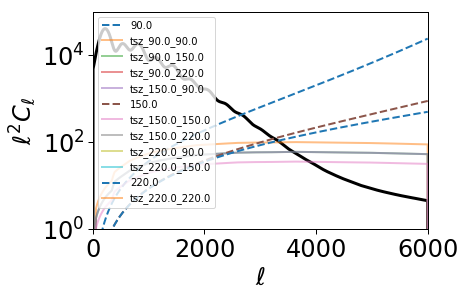

(3, 3, 80, 80)


In [14]:
# We now try to do Internal Linear Combination analysis (ILC) to reduce the variance in our measurements

# Initialize an object that knows about the power spectra of foregrounds (tSZ)
from szar import foregrounds as fgs
fnoises = fgs.fgNoises(cosmology.defaultConstants,ksz_file='../../szar/input/ksz_BBPS.txt',ksz_p_file='../../szar/input/ksz_p_BBPS.txt',tsz_cib_file='../../szar/input/sz_x_cib_template.dat',tsz_battaglia_template_csv="../../szar/input/sz_template_battaglia.csv",components=['tsz'],lmax=6000)

# Create an inverse covariance matrix required for ILC
cmb2d = cltt = theory.lCl('TT',modlmap)
n2d_90 = np.full(shape[-2:],n90)
n2d_150 = np.full(shape[-2:],n150)
n2d_220 = np.full(shape[-2:],n220)

lbeam_220 = maps.gauss_beam(ells,fwhm_220)
lbeam_150 = maps.gauss_beam(ells,fwhm_150)
lbeam_90 = maps.gauss_beam(ells,fwhm_90)

cinv2d = maps.ilc_cinv(modlmap,cmb2d,[kbeam_90,kbeam_150,kbeam_220],[90.,150.,220.],[n2d_90,n2d_150,n2d_220],['tsz'],fnoises)
cinv1d = maps.ilc_cinv(ells,ps[0,0],[lbeam_90,lbeam_150,lbeam_220],[90.,150.,220.],[ps_noise_90[0,0],ps_noise_150[0,0],ps_noise_220[0,0]],['tsz'],fnoises,plot=True)

print(cinv2d.shape)


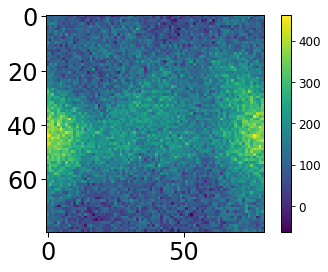

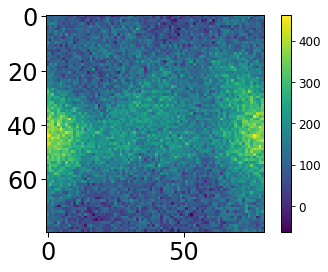

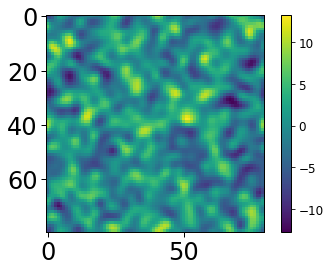

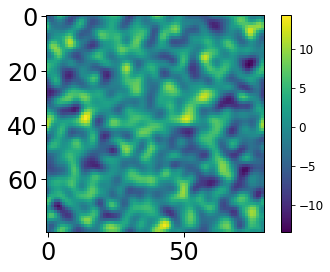

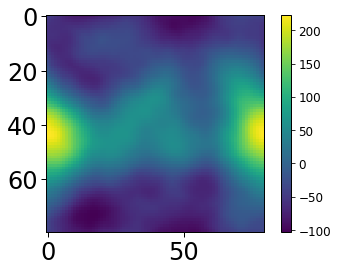

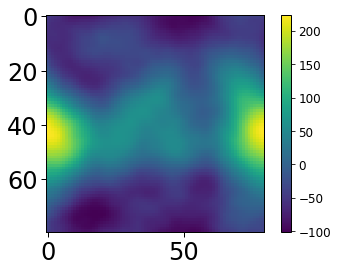

200  /  500  done...
400  /  500  done...


In [15]:
eff_beam = kbeam_90

st = stats.Stats()

yresponses = gnu(np.array([90.,150.,220.]),tcmb=2.7255)
cresponses = yresponses*0.+1.

rad_90 = np.deg2rad(fwhm_90/60)
width_90 = np.deg2rad(fwhm_90/60)

# Loop through clusters
for i,y in enumerate(ys):
    
    # Simulate the sky
    cmb = mgen.get_map()
    sz_220 = szmap(y*ytemplate,220.)
    sz_150 = szmap(y*ytemplate,150.)
    sz_90 = szmap(y*ytemplate,90.) 

    # Simulate the instrument
    noise_220 = ngen_220.get_map()
    noise_150 = ngen_150.get_map()
    noise_90 = ngen_90.get_map()
    obs_220 = maps.filter_map(cmb+sz_220,kbeam_220) + noise_220
    obs_150 = maps.filter_map(cmb+sz_150,kbeam_150) + noise_150
    obs_90 = maps.filter_map(cmb+sz_90,kbeam_90) + noise_90
    
    # Analysis starts here
    # We get the fourier transform of the stamp and deconvolve the beam
    
    
    kmask = maps.mask_kspace(shape,wcs,lmin=50,lmax=10000)
    k220 = np.nan_to_num(enmap.fft(obs_220)*kmask/kbeam_220)
    k150 = np.nan_to_num(enmap.fft(obs_150)*kmask/kbeam_150)
    k90 = np.nan_to_num(enmap.fft(obs_150)*kmask/kbeam_90)
    
    # We get the Standard ILC combination and convolve it with the worst beam
    ksilc = maps.silc([k90,k150,k220],cinv2d,response=yresponses)*eff_beam
    kcilc = maps.cilc([k90,k150,k220],cinv2d,response_a=yresponses,response_b=cresponses)*eff_beam
    map_silc = enmap.enmap(enmap.ifft(ksilc).real,wcs)
    map_cilc = enmap.enmap(enmap.ifft(kcilc).real,wcs)

    cksilc = maps.silc([k90,k150,k220],cinv2d)*eff_beam
    ckcilc = maps.cilc([k90,k150,k220],cinv2d,response_a=cresponses,response_b=yresponses)*eff_beam
    map_csilc = enmap.enmap(enmap.ifft(cksilc).real,wcs)
    map_ccilc = enmap.enmap(enmap.ifft(ckcilc).real,wcs)
    
    if i==0:
        io.plot_img(obs_90)
        io.plot_img(enmap.ifft(enmap.fft(obs_90)).real)
        io.plot_img(map_silc)
        io.plot_img(map_cilc)
        io.plot_img(map_csilc)
        io.plot_img(map_ccilc)
                        
    # We do aperture photometry on the SILC map
    ap_silc = maps.aperture_photometry(map_silc,rad_90,width_90,modrmap=modrmap)
    st.add_to_stats("silc_results",np.array((y,ap_silc)))
    st.add_to_stack("silc",map_silc)
    
    ap_cilc = maps.aperture_photometry(map_cilc,rad_90,width_90,modrmap=modrmap)
    st.add_to_stats("cilc_results",np.array((y,ap_cilc)))
    st.add_to_stack("cilc",map_cilc)
    
    ap_csilc = maps.aperture_photometry(map_csilc,rad_90,width_90,modrmap=modrmap)
    st.add_to_stats("csilc_results",np.array((y,ap_csilc)))
    st.add_to_stack("csilc",map_csilc)
    
    ap_ccilc = maps.aperture_photometry(map_ccilc,rad_90,width_90,modrmap=modrmap)
    st.add_to_stats("ccilc_results",np.array((y,ap_ccilc)))
    st.add_to_stack("ccilc",map_ccilc)
        
    
    if (i+1)%200==0: print((i+1), " / ",len(ys)," done...")
st.get_stacks()
st.get_stats()

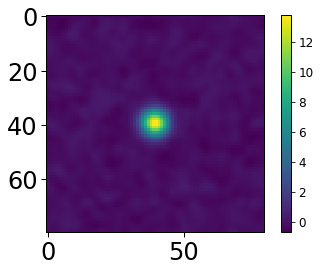

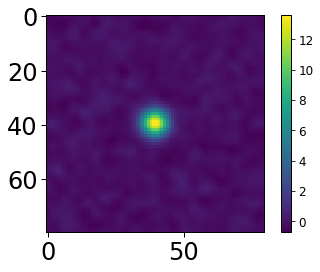

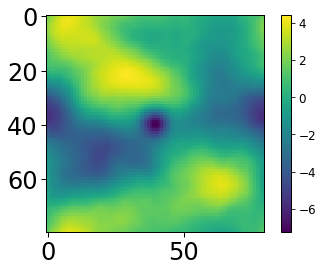

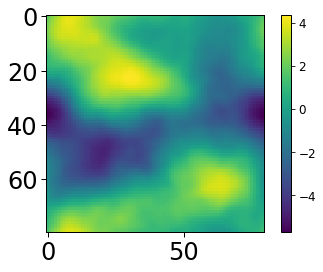

In [16]:
io.plot_img(st.stacks['silc'])
io.plot_img(st.stacks['cilc'])
io.plot_img(st.stacks['csilc'])
io.plot_img(st.stacks['ccilc'])

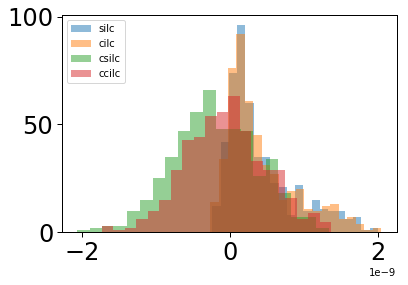

In [17]:
# Distribution of fluxes
yins = st.vectors['silc_results'][:,0]
apsilcs = st.vectors['silc_results'][:,1]
apcilcs = st.vectors['cilc_results'][:,1]
capsilcs = st.vectors['csilc_results'][:,1]
capcilcs = st.vectors['ccilc_results'][:,1]
pl = io.Plotter()
pl._ax.hist(apsilcs,bins=20,label="silc",alpha=0.5)
pl._ax.hist(apcilcs,bins=20,label="cilc",alpha=0.5)
pl._ax.hist(capsilcs,bins=20,label="csilc",alpha=0.5)
pl._ax.hist(capcilcs,bins=20,label="ccilc",alpha=0.5)
pl.legend()
pl.done()

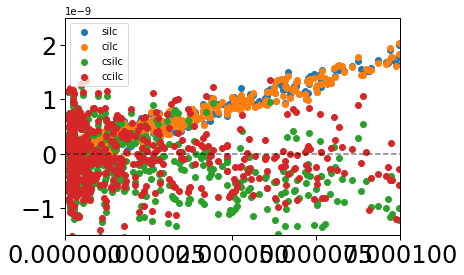

In [18]:
# Flux vs Y
pl = io.Plotter()#xscale='log')
pl._ax.scatter(yins,apsilcs,label="silc")
pl._ax.scatter(yins,apcilcs,label="cilc")
pl._ax.scatter(yins,capsilcs,label="csilc")
pl._ax.scatter(yins,capcilcs,label="ccilc")
pl._ax.set_ylim(-1.5e-9,2.5e-9)
pl._ax.set_xlim(0,1e-4)
pl.legend()
pl.hline()
pl.done()



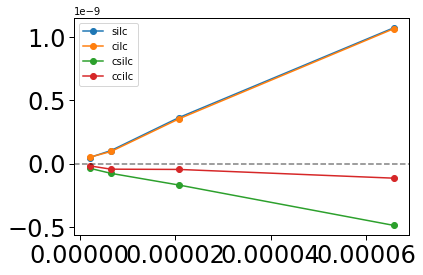

In [19]:
# Binned flux
bin_edges = np.logspace(logymin,logymax,5)
binner = stats.bin1D(bin_edges)
cents,apmeans1 = binner.binned(yins,apsilcs)
cents,apmeans2 = binner.binned(yins,apcilcs)
cents,apmeans3 = binner.binned(yins,capsilcs)
cents,apmeans4 = binner.binned(yins,capcilcs)

pl = io.Plotter()#xscale='log')
pl.add(cents,apmeans1,marker="o",label="silc")
pl.add(cents,apmeans2,marker="o",label="cilc")
pl.add(cents,apmeans3,marker="o",label="csilc")
pl.add(cents,apmeans4,marker="o",label="ccilc")
#pl.add(yins,yins,ls="--",lw=2)
pl.legend()
pl.hline()
pl.done()